# Imported Libraries

In [1]:
import os
import nltk
import math
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Activation, Input, \
#    Conv1D, MaxPool1D, Flatten, Concatenate, Add
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

# Un-comment and run the following two lines if you didn't install necessary nltk corpora yet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path_to_data = '/content/drive/MyDrive/COMP4332/Project 1_Sentiment_Analysis/data'
!rm -f data
!ln -s '/content/drive/MyDrive/COMP4332/Project 1_Sentiment_Analysis/data' data

Mounted at /content/drive


# Data Preprocessing and CNN Model (Submitted Test Prediction Model)

## Data Prepocessing

In [3]:
def load_data(split_name='train', columns=['text', 'label'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.

        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "label" column is the labels (sentiment).
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

In [4]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    # .most_common(): List the n most common elements and their counts from the most common to the least.
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))

    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        try:
            vector[i] = feats_dict[f]
        except KeyError:
            vector[i] = 1
    return vector

In [5]:
train_df = load_data('train', columns=['text', 'label'], folder='data')
valid_df = load_data('valid', columns=['id', 'text', 'label'], folder='data')
# the test set labels (the 'label' column) are unavailable! So the following code will instead return all columns
test_df = load_data('test_no_label', columns=['id', 'text'], folder='data')

select [text, label] columns from the train split
Success
select [id, text, label] columns from the valid split
Success
select [id, text] columns from the test_no_label split
Success


In [6]:
print(len(train_df), len(valid_df), len(test_df))

18000 2000 4000


In [7]:
min_freq = 4

train_tokens = [tokenize(text) for text in train_df['text']]
valid_tokens = [tokenize(text) for text in valid_df['text']]
test_tokens = [tokenize(text) for text in test_df['text']]

train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

#train_feats = [filter_stopwords(tokens) for tokens in train_stemmed]
#valid_feats = [filter_stopwords(tokens) for tokens in valid_stemmed]
#test_feats = [filter_stopwords(tokens) for tokens in test_stemmed]

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_stemmed),
    min_freq=min_freq)

max_len = 100

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_stemmed])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_stemmed])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_stemmed])

# convert labels to label_matrix
num_classes = max(train_df['label'])
train_labels= train_df['label']
valid_labels= valid_df['label']
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
test_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

Size of features: 4546


## CNN Model

In [ ]:
def build_CNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              kernel_sizes, num_filters, num_mlp_layers,
              padding="valid",
              strides=1,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param kernel_sizes: the kernel sizes of convolutional layers, type: list
    :param num_filters: the number of filters for each kernel, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param padding: the padding method in convolutional layers, type: str
    :param strides: the strides in convolutional layers, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a CNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # convolutional layers document: https://keras.io/layers/convolutional
    # pooling layers document: https://keras.io/layers/pooling/
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))

    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    emb = Embedding(input_dim=vocab_size, output_dim=embedding_size)(x)

    ################################
    ########### Conv-Pool ##########
    ################################
    # convolutional and pooling layers
    cnn_results = list()
    for kernel_size in kernel_sizes:
        # add convolutional layer
        conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, strides=strides)(emb)
        # add batch normalization layer
        if batch_norm:
            conv = BatchNormalization()(conv)
        # add activation
        conv = Activation(activation)(conv)
        # add max-pooling
        maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)
        cnn_results.append(Flatten()(maxpool))

    ################################
    ##### Fully Connected Layer ####
    ################################
    h = Concatenate()(cnn_results) if len(kernel_sizes) > 1 else cnn_results[0]
    h = Dropout(dropout_rate, seed=0)(h)
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    learning_rate = keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=100, decay_rate=0.98, staircase=True)
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

    return model

In [ ]:
os.makedirs("models", exist_ok=True)

model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes, dropout_rate=0.3,
                  kernel_sizes=[1,2,3], num_filters=100, num_mlp_layers=2,
                  activation="relu", optimizer="Adam")
#model.summary()

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

np.random.seed(0)
tf.random.set_seed(0)
cnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data= (valid_feats_matrix , test_label_matrix),
                    epochs=10, batch_size=100, verbose=2,
                    callbacks=[checkpointer])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, test_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

Epoch 1/10
180/180 - 30s - loss: 1.3843 - accuracy: 0.3988 - val_loss: 1.2047 - val_accuracy: 0.4875 - 30s/epoch - 167ms/step
Epoch 2/10
180/180 - 24s - loss: 1.0958 - accuracy: 0.5433 - val_loss: 1.1139 - val_accuracy: 0.5430 - 24s/epoch - 131ms/step
Epoch 3/10
180/180 - 24s - loss: 0.9454 - accuracy: 0.6107 - val_loss: 1.1302 - val_accuracy: 0.5290 - 24s/epoch - 132ms/step
Epoch 4/10
180/180 - 29s - loss: 0.8066 - accuracy: 0.6787 - val_loss: 1.1825 - val_accuracy: 0.5285 - 29s/epoch - 160ms/step
Epoch 5/10
180/180 - 24s - loss: 0.6860 - accuracy: 0.7324 - val_loss: 1.2910 - val_accuracy: 0.5130 - 24s/epoch - 136ms/step
Epoch 6/10
180/180 - 23s - loss: 0.5722 - accuracy: 0.7802 - val_loss: 1.3956 - val_accuracy: 0.5100 - 23s/epoch - 131ms/step
Epoch 7/10
180/180 - 25s - loss: 0.4750 - accuracy: 0.8234 - val_loss: 1.5445 - val_accuracy: 0.5025 - 25s/epoch - 140ms/step
Epoch 8/10
180/180 - 25s - loss: 0.3842 - accuracy: 0.8629 - val_loss: 1.6858 - val_accuracy: 0.5060 - 25s/epoch - 139

In [ ]:
%cd "/content/drive/MyDrive/COMP4332/Project 1_Sentiment_Analysis"
model.save("cnn_model.h5")

/content/drive/MyDrive/COMP4332/Project 1_Sentiment_Analysis


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
model = keras.models.load_model("/content/drive/MyDrive/COMP4332/Project 1_Sentiment_Analysis/cnn_model.h5")
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 100, 100)             454600    ['input_10[0][0]']            
                                                                                                  
 conv1d_27 (Conv1D)          (None, 100, 100)             10100     ['embedding_9[0][0]']         
                                                                                                  
 conv1d_28 (Conv1D)          (None, 99, 100)              20100     ['embedding_9[0][0]']         
                                                                                            

## Evaluate Validation Data and Predict Test Data

In [9]:
test_output = model.predict(test_feats_matrix, batch_size=100, verbose='auto')
valid_output = model.predict(valid_feats_matrix, batch_size=100, verbose='auto')
test_pred_labels = test_output.argmax(axis=-1) +1
valid_pred_labels = valid_output.argmax(axis=-1) +1
test_pred = pd.DataFrame(data={
    'id': test_df['id'],
    'label': test_pred_labels
})
test_pred.to_csv(f'/content/drive/MyDrive/COMP4332/Project 1_Sentiment_Analysis/data/pred.csv', index=False)
valid_pred = pd.DataFrame(data={
    'id': valid_df['id'],
    'label': valid_pred_labels
})
valid_pred.to_csv(f'/content/drive/MyDrive/COMP4332/Project 1_Sentiment_Analysis/data/valid_pred.csv', index=False)

20/20 [==============================] - 1s 28ms/step


In [10]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

if __name__ == "__main__":
    ans = pd.read_csv("data/valid.csv", usecols=["id", "label"])
    pred = pd.read_csv("data/valid_pred.csv", usecols=["id", "label"])
    df = pd.merge(ans, pred, how="left", on=["id"])
    df.fillna(0, inplace=True)
    acc = accuracy_score(df["label_x"], df["label_y"])
    p, r, f1, _ = precision_recall_fscore_support(df["label_x"], df["label_y"], average="macro")
    print("accuracy:", acc, "\tprecision:", p, "\trecall:", r, "\tf1:", f1)

accuracy: 0.543 	precision: 0.5238321267747666 	recall: 0.5139075535498917 	f1: 0.5143458789860127


# Models built by CHAN, Chun Hin

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
ps = PorterStemmer()

def filter_stopword(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code

    # stoplist = set(stopwords.words('english'))

    results = list()
    for token in tokens:
        if token not in stoplist and not token.isnumeric():
            results.append(token)
    return results

    # return [token for token in tokens if token not in stopwords and not token.isnumeric()]

Visualize the class label distribution first

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [ ]:
train_df = load_data('train')
valid_df = load_data('valid')
x_train = train_df['text']
y_train = train_df['label']
x_valid = valid_df['text']
y_valid = valid_df['label']

select [text, label] columns from the train split
Success
select [text, label] columns from the valid split
Success


### Distribution of training dataset

In [ ]:
print("The distribution of different labels in training dataset:\n")
y_train.value_counts(sort = True, dropna = False)

The distribution of different labels in training dataset:



label
5    4546
4    4481
3    4480
1    2522
2    1971
Name: count, dtype: int64

Axes(0.125,0.11;0.775x0.77)


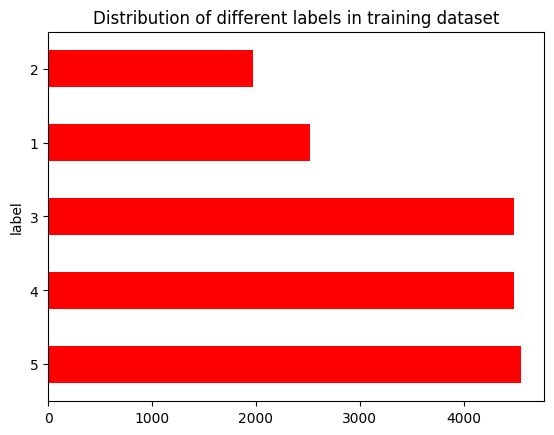

In [ ]:
print(y_train.value_counts(sort = True, dropna = False).plot(kind = "barh", title = "Distribution of different labels in training dataset", color = "red"))

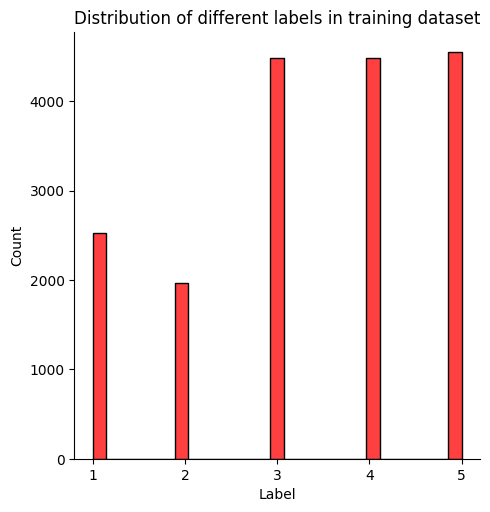

In [ ]:
# visualize the distribution of different labels in training dataset
train_label_plot = sns.displot(y_train, color = "red")
train_label_plot.set(xlabel = "Label", ylabel = "Count", title = 'Distribution of different labels in training dataset', xticks = [1, 2, 3, 4, 5])

### Distribution of validation dataset

In [ ]:
print("The distribution of different labels in validation dataset:\n")
y_valid.value_counts(sort = True, dropna = False)

The distribution of different labels in validation dataset:



label
4    523
3    508
5    476
1    295
2    198
Name: count, dtype: int64

Axes(0.125,0.11;0.775x0.77)


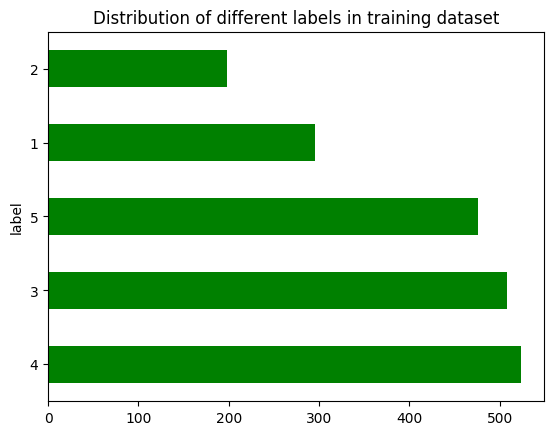

In [ ]:
print(y_valid.value_counts(sort = True, dropna = False).plot(kind = "barh", title = "Distribution of different labels in training dataset", color = "green"))

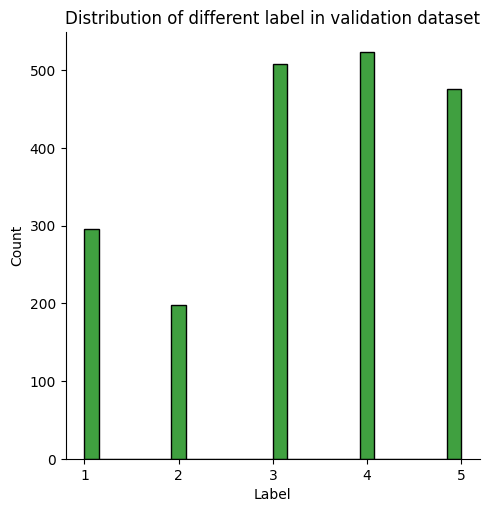

In [ ]:
# visualize the distribution of different labels in validation dataset
validate_label_plot = sns.displot(y_valid, color = "green")
validate_label_plot.set(xlabel = "Label", ylabel = "Count", title = 'Distribution of different label in validation dataset', xticks = [1, 2, 3, 4, 5])

# Prototype Model A (modify from the hard baseline)

In [ ]:
classifier = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('network', MLPClassifier(hidden_layer_sizes = (16, 16, 16), activation = 'tanh', solver = 'adam', learning_rate = 'adaptive', max_iter = 1000, shuffle = True, early_stopping = True))])

print(classifier)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7d3a427780d0>)),
                ('network',
                 MLPClassifier(activation='tanh', early_stopping=True,
                               hidden_layer_sizes=(16, 16, 16),
                               learning_rate='adaptive', max_iter=1000))])


In [ ]:
classifier.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7d3a427780d0>)),
                ('network',
                 MLPClassifier(activation='tanh', early_stopping=True,
                               hidden_layer_sizes=(16, 16, 16),
                               learning_rate='adaptive', max_iter=1000))])

In [ ]:
y_pred = classifier.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1       0.55      0.60      0.57       295
           2       0.00      0.00      0.00       198
           3       0.48      0.63      0.54       508
           4       0.53      0.41      0.46       523
           5       0.61      0.75      0.67       476

    accuracy                           0.54      2000
   macro avg       0.43      0.48      0.45      2000
weighted avg       0.48      0.54      0.50      2000




[[178   2  77  13  25]
 [ 75   0 104   9  10]
 [ 46   0 322  99  41]
 [ 15   0 139 215 154]
 [ 12   0  35  73 356]]
accuracy 0.5355


# Prototype Model B (self customized MLP using Keras)

In [ ]:
import random
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from keras import Input
from keras.models import Sequential, Model
from keras.initializers import GlorotNormal, HeNormal, LecunNormal
from keras.regularizers import L1, L2
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dense, Activation, Dropout, BatchNormalization, LayerNormalization, Activation, Input, Add, Concatenate, Bidirectional, LSTM, GRU, Embedding, Flatten, GlobalAveragePooling1D

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# stopwords = set(stopwords.words("english"))
# ps = PorterStemmer()

# just to ignore the matplotlib warnings to make the plots look better
import warnings
warnings.filterwarnings('ignore')

In [ ]:
random.seed(4332)
np.random.seed(4332)
tf.random.set_seed(4332)

In [ ]:
train_df = load_data('train')
valid_df = load_data('valid')
x_train = train_df['text']
y_train = train_df['label']
x_valid = valid_df['text']
y_valid = valid_df['label']

select [text, label] columns from the train split
Success
select [text, label] columns from the valid split
Success


In [ ]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))

    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

In [ ]:
# extract features

# get the word tokens
train_tokens = [tokenize(text) for text in x_train]
validation_tokens = [tokenize(text) for text in x_valid]

# lowercase
train_tokens = [lower(t) for t in train_tokens]
validation_tokens = [lower(t) for t in validation_tokens]

# stemming
train_stemmed = [stem(tokens) for tokens in train_tokens]
validation_stemmed = [stem(tokens) for tokens in validation_tokens]

# filter the stopwords
train_stemmed = [filter_stopword(tokens) for tokens in train_stemmed]
validation_stemmed = [filter_stopword(tokens) for tokens in validation_stemmed]

# get the bigram list
train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
validation_2_gram = [n_gram(tokens, 2) for tokens in validation_stemmed]

# get the trigram list
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
validation_3_gram = [n_gram(tokens, 3) for tokens in validation_stemmed]


# build the feature list
train_feats = list()
for i in range(len(x_train)):
    train_feats.append(
        train_stemmed[i] + train_2_gram[i] + train_3_gram[i])

validation_feats = list()
for i in range(len(x_valid)):
    validation_feats.append(
        validation_stemmed[i] + validation_2_gram[i] + validation_3_gram[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(chain.from_iterable(train_feats), min_freq = 6)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack([get_onehot_vector(f, feats_dict) for f in train_feats])
validation_feats_matrix = np.vstack([get_onehot_vector(f, feats_dict) for f in validation_feats])

# convert labels to label_matrix
###num_classes = max(y_train)
num_classes = y_train.nunique()
print("number of classes:", num_classes)

# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(y_train - 1, num_classes = num_classes)
validation_label_matrix = keras.utils.to_categorical(y_valid - 1, num_classes = num_classes)

Size of features: 12855
number of classes: 5


In [ ]:
print("Shape of train_feats_matrix:")
print(train_feats_matrix.shape)

Shape of train_feats_matrix:
(18000, 12855)


In [ ]:
print("Shape of validation_feats_matrix:")
print(validation_feats_matrix.shape)

Shape of validation_feats_matrix:
(2000, 12855)


In [ ]:
def build_model_3(input_shape, num_classes = 5, seed = 4332):

    model = Sequential(name = "model_3")

    # model.add(Embedding(input_dim = input_dim, output_dim = 64, input_length = input_length, embeddings_initializer = GlorotNormal(seed = 4332), name = "embed"))

    # model.add(GlobalAveragePooling1D(name = "global_avg_pool_1d"))

    model.add(Dense(units = 64, activation = "relu", kernel_initializer = HeNormal(seed = seed), kernel_regularizer = L2(0.005), name = "dense1", input_shape = input_shape))

    model.add(Dense(units = 32, activation = "relu", kernel_initializer = HeNormal(seed = seed), kernel_regularizer = L2(0.005), name = "dense2"))
    model.add(Dropout(rate = 0.1, seed = seed, name = "dropout1"))
    model.add(BatchNormalization(name = "batch_norm1"))

    model.add(Dense(units = 20, activation = "relu", name = "dense3"))
    model.add(Dropout(rate = 0.1, name = "dropout2"))
    # model.add(BatchNormalization(name = "batch_norm2"))

    model.add(Dense(units = 16, activation = "relu", name = "dense4"))

    model.add(Dense(units = num_classes, activation = "softmax", name = "dense5"))

    model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = 0.005, weight_decay = 1e-4), metrics = ["accuracy"])


    return model

In [ ]:
model_3 = build_model_3(input_shape = (train_feats_matrix.shape[-1], ), num_classes = num_classes, seed = 4332)

In [ ]:
model_3.summary(show_trainable = True)

Model: "model_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 dense1 (Dense)              (None, 64)                822784    Y          
                                                                            
 dense2 (Dense)              (None, 32)                2080      Y          
                                                                            
 dropout1 (Dropout)          (None, 32)                0         Y          
                                                                            
 batch_norm1 (BatchNormaliz  (None, 32)                128       Y          
 ation)                                                                     
                                                                            
 dense3 (Dense)              (None, 20)                660       Y          
                                                           

In [ ]:
history = model_3.fit(train_feats_matrix, train_label_matrix, validation_split = 0.2, epochs = 15, batch_size = 32, verbose = 2)

Epoch 1/15
450/450 - 10s - loss: 2.0371 - accuracy: 0.4299 - val_loss: 1.8521 - val_accuracy: 0.4750 - 10s/epoch - 21ms/step
Epoch 2/15
450/450 - 7s - loss: 1.7318 - accuracy: 0.4667 - val_loss: 1.7022 - val_accuracy: 0.4686 - 7s/epoch - 16ms/step
Epoch 3/15
450/450 - 7s - loss: 1.6001 - accuracy: 0.4737 - val_loss: 1.5396 - val_accuracy: 0.4931 - 7s/epoch - 15ms/step
Epoch 4/15
450/450 - 8s - loss: 1.5416 - accuracy: 0.4884 - val_loss: 1.5108 - val_accuracy: 0.4950 - 8s/epoch - 18ms/step
Epoch 5/15
450/450 - 6s - loss: 1.5227 - accuracy: 0.4850 - val_loss: 1.5253 - val_accuracy: 0.4956 - 6s/epoch - 14ms/step
Epoch 6/15
450/450 - 9s - loss: 1.5171 - accuracy: 0.4856 - val_loss: 1.5013 - val_accuracy: 0.4900 - 9s/epoch - 19ms/step
Epoch 7/15
450/450 - 6s - loss: 1.4977 - accuracy: 0.4937 - val_loss: 1.4790 - val_accuracy: 0.4975 - 6s/epoch - 14ms/step
Epoch 8/15
450/450 - 8s - loss: 1.4897 - accuracy: 0.4957 - val_loss: 1.4694 - val_accuracy: 0.5011 - 8s/epoch - 17ms/step
Epoch 9/15
450

In [ ]:
train_score = model_3.evaluate(train_feats_matrix, train_label_matrix, batch_size = 64)
validation_score = model_3.evaluate(validation_feats_matrix, validation_label_matrix, batch_size = 64)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", validation_score[0], "validation accuracy", validation_score[1])

32/32 [==============================] - 0s 11ms/step - loss: 1.4632 - accuracy: 0.4690
training loss: 1.3135472536087036 training accuracy 0.550777792930603
validation loss: 1.463200569152832 validation accuracy 0.4690000116825104


In [ ]:
predicted_validation_softmax = model_3.predict(validation_feats_matrix)
predicted_validation_label_onehot = np.argmax(predicted_validation_softmax, axis = 1)

true_validation_label_onehot = np.argmax(validation_label_matrix, axis = 1)

63/63 [==============================] - 0s 4ms/step


In [ ]:
print(classification_report(y_true = true_validation_label_onehot, y_pred = predicted_validation_label_onehot))
print("\n\n")
print(confusion_matrix(y_true = true_validation_label_onehot, y_pred = predicted_validation_label_onehot))
print("\n\n")
print('validation accuracy:', np.mean(true_validation_label_onehot == predicted_validation_label_onehot))

              precision    recall  f1-score   support

           0       0.50      0.60      0.54       295
           1       0.00      0.00      0.00       198
           2       0.43      0.56      0.49       508
           3       0.44      0.27      0.34       523
           4       0.50      0.71      0.59       476

    accuracy                           0.47      2000
   macro avg       0.37      0.43      0.39      2000
weighted avg       0.42      0.47      0.43      2000




[[176   0  64   9  46]
 [ 79   0  94   9  16]
 [ 60   0 283  87  78]
 [ 19   0 170 143 191]
 [ 18   0  43  79 336]]



validation accuracy: 0.469
